In [1]:
import math
import random
import numpy as np
from collections import deque

from unityagents import UnityEnvironment

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils

import csv
import time
import datetime

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h1>CUDA</h1>

In [3]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

<h1>Q-learning Network</h1>

In [4]:
class QNetwork(nn.Module):
    
    def __init__(self, state_size, action_size, hidden_size=64):
        
        super(QNetwork, self).__init__()
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.layers = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )
        
    def forward(self, state):
        return self.layers(state)
    
    def act(self, state, epsilon=0):
        
        if training_mode == True:
        
            if random.random() > epsilon:

                # gets the best action according to the policy being trained
                action = self.act_optimaly(state)

            else:
                
                # gets a random action
                action = random.randrange(self.action_size)
        else:
            
            # gets the best action according to the already trained policy
            action = self.act_optimaly(state)
                
        return action
    
    def act_optimaly(self, state):
        
        # gets the best action indicated by the current policy
        state = torch.FloatTensor(state).unsqueeze(0).to(device)

        self.eval()
        with torch.no_grad():
            q_value = self.forward(state)
        self.train()

        action  = q_value.max(1)[1].item()
        
        return action
        

<h1>Dueling Network</h1>

In [5]:
class DuelingQNetwork(nn.Module):
    
    def __init__(self, state_size, action_size, hidden_size=64):
        
        super(DuelingQNetwork, self).__init__()
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.initial_layers = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )
        
        self.value = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
        
    
    def forward(self, state):
        
        x = self.initial_layers(state)
        
        advantage = self.advantage(x)
        
        value = self.value(x)
        
        return value + advantage - advantage.mean()
    
    
    def act(self, state, epsilon=0):
        
        if training_mode == True:
        
            if random.random() > epsilon:

                # gets the best action according to the policy being trained
                action = self.act_optimaly(state)

            else:
                
                # gets a random action
                action = random.randrange(self.action_size)
        else:
            
            # gets the best action according to the already trained policy
            action = self.act_optimaly(state)
                
        return action
    
    def act_optimaly(self, state):
        
        # gets the best action indicated by the current policy
        state = torch.FloatTensor(state).unsqueeze(0).to(device)

        self.eval()
        with torch.no_grad():
            q_value = self.forward(state)
        self.train()

        action  = q_value.max(1)[1].item()
        
        return action

<h1>Custom Loss Functions</h1>

In [6]:
class CustomMSELoss(nn.Module):

    def __init__(self):
        super(CustomMSELoss, self).__init__()

    def forward(self, input_tensor, target_tensor):

        # calculates the Mean Squared Error between the input and target tensors
        batch_loss_tensor = (input_tensor - target_tensor) ** 2 
        
        # returns the total loss tensor
        return batch_loss_tensor.sum()

class CustomMSEWeightedLoss(nn.Module):

    def __init__(self):
        super(CustomMSEWeightedLoss, self).__init__()

    def forward(self, input_tensor, target_tensor, weights_list):

        # calculates the Mean Squared Error between the input and target tensors
        batch_loss_tensor = (input_tensor - target_tensor) ** 2

        # creates a tensor to hold the weights
        weights_tensor = torch.autograd.Variable(torch.Tensor(weights_list))

        # multiplies by the weights
        weighted_batch_loss = weights_tensor * batch_loss_tensor

        # gets the total loss
        weighted_loss_tensor = weighted_batch_loss.sum()
        
        return weighted_loss_tensor

    
class CustomHuberLoss(nn.Module):

    def __init__(self):
        super(CustomHuberLoss, self).__init__()

    def forward(self, input_tensor, target_tensor, threshold=0.5):
        
        # like mean-squared-error - MSE because the error is small, and # like mean-absolute-error - MAE when error is large
        batch_loss_tensor = (torch.abs(input_tensor - target_tensor) < threshold).float() * (((input_tensor - target_tensor) ** 2) * threshold) + (torch.abs(input_tensor - target_tensor) >= threshold).float() * (torch.abs(input_tensor - target_tensor) - threshold)
        
        #print("batch_loss_tensor", batch_loss_tensor)
        
        # returns the total loss tensor
        return batch_loss_tensor.sum()

class CustomWeightedHuberLoss(nn.Module):

    def __init__(self):
        super(CustomWeightedHuberLoss, self).__init__()

    def forward(self, input_tensor, target_tensor, weights_list, threshold=0.5):

        # like mean-squared-error - MSE because the error is small, and # like mean-absolute-error - MAE when error is large
        batch_loss_tensor = (torch.abs(input_tensor - target_tensor) < threshold).float() * (((input_tensor - target_tensor) ** 2) * threshold) + (torch.abs(input_tensor - target_tensor) >= threshold).float() * (torch.abs(input_tensor - target_tensor) - threshold)
        
        # creates a tensor to hold the weights
        weights_tensor = torch.autograd.Variable(torch.Tensor(weights_list))

        # multiplies by the weights
        weighted_batch_loss = weights_tensor * batch_loss_tensor

        # gets the total loss
        weighted_loss_tensor = weighted_batch_loss.sum()
        #print("weighted_loss_tensor", weighted_loss_tensor)
        
        return weighted_loss_tensor

<h1>Replay Buffer</h1>

In [7]:
# https://github.com/openai/baselines/blob/master/baselines/deepq/replay_buffer.py

from segment_tree import SumSegmentTree, MinSegmentTree

class ReplayBuffer(object):

    def __init__(self, buffer_size, batch_size, seed):
        
        self._storage = []
        self._maxsize = buffer_size
        self.batch_size = batch_size
        self._next_idx = 0

        self.seed = random.seed(seed)

    def __len__(self):
        return len(self._storage)

    def add(self, state, action, reward, next_state, done):

        e = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(e)
        else:
            self._storage[self._next_idx] = e

        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_samples(self, indices):

        states, actions, rewards, next_states, dones = [], [], [], [], []

        for i in indices:

            data = self._storage[i]

            state, action, reward, next_state, done = data

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)

        return (np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones))

    def sample(self):

        indices = [random.randint(0, len(self._storage) - 1) for _ in range(self.batch_size)]

        return self._encode_samples(indices)

<h1>Prioritised Replay Buffer</h1>

In [8]:
class PrioritizedReplayBuffer(ReplayBuffer):

    def __init__(self, buffer_size, batch_size, seed, alpha, epsilon):

        super(PrioritizedReplayBuffer, self).__init__(buffer_size, batch_size, seed)

        assert alpha >= 0

        self._alpha = alpha
        self._epsilon = epsilon

        it_capacity = 1

        while it_capacity < buffer_size:
            it_capacity *= 2

        self._it_sum = SumSegmentTree(it_capacity)
        self._it_min = MinSegmentTree(it_capacity)

        self._max_priority = 1.0


    def add(self, *args, **kwargs):

        idx = self._next_idx

        super().add(*args, **kwargs)

        self._it_sum[idx] = (self._max_priority ** self._alpha) + self._epsilon
        self._it_min[idx] = (self._max_priority ** self._alpha) + self._epsilon


    def _sample_proportional(self):

        res = []

        for _ in range(self.batch_size):

            mass = random.random() * self._it_sum.sum(0, len(self._storage) - 1)

            idx = self._it_sum.find_prefixsum_idx(mass)

            res.append(idx)

        return res


    def sample(self, beta):

        # gets a sample of indices
        indices = self._sample_proportional()

        # retrieves the states, actions, rewards, next_states and dones for the sampled indices
        states, actions, rewards, next_states, dones = self._encode_samples(indices)

        # calculates new weights
        normalised_is_weights = []

        p_min = self._it_min.min() / self._it_sum.sum()

        # gets the maximum weight for normalisation purposes
        max_weight = (p_min * len(self._storage)) ** (-beta)

        for idx in indices:
            
            # computes the sample probability
            p_sample = self._it_sum[idx] / self._it_sum.sum()

            # computes the new weight using the current annealed beta
            weight = (p_sample * len(self._storage)) ** (-beta)

            # normalises the weight to scale the update down
            normalised_is_weights.append(weight / max_weight)

        return (states, actions, rewards, next_states, dones, indices, normalised_is_weights)


    def update_priorities(self, indices, priorities):

        for idx, priority in zip(indices, priorities):

            self._it_sum[idx] = (priority ** self._alpha) +  self._epsilon
            self._it_min[idx] = (priority ** self._alpha) +  self._epsilon

            self._max_priority = max(self._max_priority, priority)

<h1>DQN Agent</h1>

In [9]:
class Agent():

    def __init__(self, state_dim, action_dim, replay_buffer_size=100000, batch_size=128, learning_rate=5e-4, seed=0, per_alpha=0.6, per_epsilon=0.01):

        # states and action sizes
        self.state_size = state_dim
        self.action_size = action_dim
        
        # seed to be used in random calls
        self.seed = random.seed(seed)
        
        # instantiates a new replay buffer
        self.replay_buffer_size = replay_buffer_size
        
        # size of batch of experiments to use when training the agent's Q-network
        self.batch_size  = batch_size
        
        # stores the hyper-parameters that control 
        self.per_alpha = per_alpha
        self.per_epsilon = per_epsilon
        
        # instantiates a replay buffer
        if use_prioritised_replay == True:
            self.memory = PrioritizedReplayBuffer(self.replay_buffer_size, self.batch_size, self.seed, self.per_alpha, self.per_epsilon)
        else:
            self.memory = ReplayBuffer(self.replay_buffer_size, self.batch_size, self.seed)

        # instantiates the principal and target Q-Networks
        if use_duelling_networks == True:
            self.qnetwork_local = DuelingQNetwork(self.state_size, self.action_size).to(device)
            self.qnetwork_target = DuelingQNetwork(self.state_size, self.action_size).to(device)
        else:
            self.qnetwork_local = QNetwork(self.state_size, self.action_size).to(device)
            self.qnetwork_target = QNetwork(self.state_size, self.action_size).to(device)
        
        # synchronises the networks
        self.hard_update(self.qnetwork_local, self.qnetwork_target)
        
        # optimiser for the principal network neing trained
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = learning_rate)
        
        # number of steps that the agent performs before learning
        self.steps_to_learning = 1
        
        # number of steps to take before copying the local networks' parameters to the target networks
        self.target_network_parameter_update_steps = 20
        
    
    def act(self, state, epsilon=0):

        # gets an action from the current policy
        return self.qnetwork_local.act(state, epsilon)
        
    
    def step(self, step, state, action, reward, next_state, done, per_beta):
        
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # learns from experiences in the replay buffer
        self.learn(step, per_beta)


    def learn(self, step, per_beta, gamma=0.99, tau=1e-3):

        # if the replay buffer has enough experiences then we can start learning from them in mini-batches
        if len(self.memory) > self.batch_size:
            
            # only learn every n steps: stability
            if step % self.steps_to_learning == 0:

                # collects a mini-batch of experiences from the replay buffer
                if use_prioritised_replay == True:
                    experiences = self.memory.sample(per_beta)
                    states, actions, rewards, next_states, dones, indices, normalised_is_weights = experiences
                else:
                    experiences = self.memory.sample()
                    states, actions, rewards, next_states, dones = experiences
        
                # converts the numpy arrays to torch tensors
                states_tensor      = torch.FloatTensor(np.float32(states)).to(device)
                actions_tensor     = torch.LongTensor(actions).to(device)
                rewards_tensor     = torch.FloatTensor(np.float32(rewards)).to(device)
                next_states_tensor = torch.FloatTensor(np.float32(next_states)).to(device)
                dones_tensor       = torch.FloatTensor(np.float32(dones)).to(device)
                
                # gets the state-action values for the current state (64x4) matrix
                online_current_q_values = self.qnetwork_local.forward(states_tensor)
                
                # gets the state-action values of the selected actions for the current state (64x1) matrix
                online_predicted_q_value = online_current_q_values.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)
                
                # gets the state-action values for the next state (64x4) matrix
                online_next_q_values = self.qnetwork_local.forward(next_states_tensor)
                
                # ---------------------------------------------------------------------------------------------------
                
                # gets the Q-values for the next state and for all actions.
                # this will be used for the target estimations and for the Double Q-learning evaluation step
                
                # gets the state-action values for the next state from the target network (64x4) matrix
                target_next_q_values = self.qnetwork_target.forward(next_states_tensor)
                
                # ---------------------------------------------------------------------------------------------------
                
                if use_double_q_learning == True:
                
                    # action selection step in Double Q-learning
                    #
                    # gets the maximum state-action values and the corresponding maximising action
                    maximum_next_q_values_and_actions = torch.max(online_next_q_values, 1)

                    # gets the maximising actions only
                    maximum_actions = maximum_next_q_values_and_actions[1]
                    
                    # adds an extra dimension to the actions tensor
                    maximum_actions_unsqueezed = maximum_actions.unsqueeze(1)
                    
                    # action evaluation step in Double Q-learning
                    #
                    # gets the state-action values of the selected maximising actions (64x1)
                    target_next_q_value = target_next_q_values.gather(1, maximum_actions_unsqueezed).squeeze(1)
                    
                else:
                    
                    # gets the state-action values of the maximising actions (64x1)
                    target_next_q_value = target_next_q_values.max(1)[0]
                
                # ---------------------------------------------------------------------------------------------------
                
                # calculates the expected state-action values using the Bellman equation
                expected_q_value = rewards_tensor + gamma * target_next_q_value * (1 - dones_tensor)
                
                # ---------------------------------------------------------------------------------------------------

                # compares the expected and obtained state-action values
                if use_huber_loss == True:
                    
                    if use_prioritised_replay == True:
                        loss_fn = CustomWeightedHuberLoss()
                        loss = loss_fn(online_predicted_q_value, expected_q_value, normalised_is_weights)
                    else:
                        loss_fn = CustomHuberLoss()
                        loss = loss_fn(online_predicted_q_value, expected_q_value)
                else:
                    
                    if use_prioritised_replay == True:
                        loss_fn = CustomMSEWeightedLoss()
                        loss = loss_fn(online_predicted_q_value, expected_q_value, normalised_is_weights)
                    else:
                        loss_fn = CustomMSELoss()
                        loss = loss_fn(online_predicted_q_value, expected_q_value)
                
                # ---------------------------------------------------------------------------------------------------
                
                if use_prioritised_replay == True:
                    
                    # gets the td-errors as a numpy array for the replay buffer update
                    td_errors = abs(expected_q_value - online_predicted_q_value).detach().numpy()

                    # update the batch experiences priorities according to the td-errors
                    priorities = np.power(np.abs(td_errors) + self.per_epsilon, self.per_alpha)

                    # updates the sampled experiences priorities
                    self.memory.update_priorities(indices, priorities)

                # ---------------------------------------------------------------------------------------------------
                
                # clears the gradients
                self.optimizer.zero_grad()

                # performs a backward pass on the network
                loss.backward()
                
                # normalises the gradients of the principal network
                if clip_gradients == True:
                    torch.nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 1)

                # performs a parameter update based on the current gradients and the chosen update rule (whe are using adam)
                self.optimizer.step()

                # updates the target network
                if step % self.target_network_parameter_update_steps == 0:
                    
                    # copies all paramters from the principal to the target network
                    self.hard_update(self.qnetwork_local, self.qnetwork_target)
                    

    def hard_update(self, local_model, target_model):
        target_model.load_state_dict(local_model.state_dict())

        
    def soft_update(self, local_model, target_model, tau):

        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)


    def save_agent_model(self, model_path):

        # saves the actor model parameters for later usage in test or production
        torch.save(self.qnetwork_local.state_dict(), model_path)


    def load_agent_model(self, model_path):
        
        # loads a saved model for inference purposes
        self.qnetwork_local.load_state_dict(torch.load(model_path))
        

<h1>Auxiliary Functions</h1>

In [10]:
def plot_scores(i_episode, scores):
    clear_output(True)

    plt.figure(figsize=(30,5))

    plt.subplot(131)

    plt.title('Episode %s - Last episode average score: %s' % (i_episode, scores[-1]))
    plt.ylabel('Score')
    plt.xlabel('Episode #')

    plt.grid(True)

    plt.plot(np.arange(1, len(scores) + 1), scores)

    plt.show()

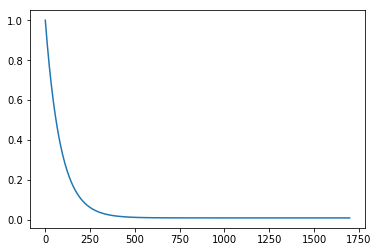

In [11]:
episodes = 1700

get_episode_epsilon = lambda episode_idx, eps_greedy_start, eps_greedy_final, eps_greedy_decay: eps_greedy_final + (eps_greedy_start - eps_greedy_final) * math.exp(-1. * episode_idx / eps_greedy_decay)

epsilon_greedy_decay_schedule = [get_episode_epsilon(i, 1.0, 0.01, (episodes / 20)) for i in range(episodes)]

plt.plot(epsilon_greedy_decay_schedule)


<h1>Training Routine</h1>

In [12]:
def train(number_of_episodes=1700, max_steps_per_episode=1000, average_score_episodes=100, print_every_episodes=10, print_every_steps=1000, eps_greedy_start=1.0, eps_greedy_end=0.01, per_beta0=0.4):

    # scores bookkeeping
    last_100_episodes_scores = deque(maxlen = average_score_episodes)
    scores_log = []
    
    # instantiates the agent
    agent = Agent(state_size, action_size)

    # starts counter in seconds
    time_start = time.time()

    # calculates our epsilon-greedy decay rate
    epsilon_greedy_decay_rate = (number_of_episodes / 20)
    
    # builds our epsilon-greedy exploration decay schedule
    epsilon_greedy_decay_schedule = [get_episode_epsilon(i, eps_greedy_start, eps_greedy_end, epsilon_greedy_decay_rate) for i in range(number_of_episodes)]
    
    for i_episode in range(1, number_of_episodes + 1):

        # calculates a new prioritised experience replay beta to be used for importance sampling bias correction
        per_beta = per_beta0 + i_episode * (1 - per_beta0) / number_of_episodes
        
        # gets a new epsilon_greedy for this episode
        epsilon_greedy = epsilon_greedy_decay_schedule[i_episode - 1]
        
        # resets the environment
        env_info = env.reset(train_mode = True)[brain_name]

        # gets the current state of the environment (for each agent)
        state = env_info.vector_observations[0]

        # initializes the episode's total score
        episode_total_score = 0

        for step in range(1, max_steps_per_episode + 1):

            # gets an action from the current policy using an epsilon-greed exploratory strategy
            action = agent.act(state, epsilon_greedy)

            # takes a step in the environment
            env_info = env.step(action)[brain_name]

            # gets reward, next_state and done
            reward = env_info.rewards[0]
            next_state = env_info.vector_observations[0]
            done = env_info.local_done[0]
                
            # takes a step in the agent
            agent.step(step, state, action, reward, next_state, done, per_beta)

            # sets the next state
            state = next_state

            # updates the current episode's score
            episode_total_score += reward
            
            # echoes the episode's current total reward
            if step % print_every_steps == 0:
                print("\nEpisode {} step {} total reward so far -> {}".format(i_episode, step, episode_total_score))
                
            if done:
                break
                
        # adds this episode average score to the complete scores log
        scores_log.append(episode_total_score)
        
        # adds this episode's total score to the last 100 scores average deque
        last_100_episodes_scores.append(episode_total_score)
        
        # plots the latest 100 episodes average reward
        if i_episode % print_every_episodes == 0:
            plot_scores(i_episode, scores_log)
            print("\nEpisode {} average score so far -> {}".format(i_episode, np.mean(last_100_episodes_scores)))
            
        # checks if the environment is solved
        if np.mean(last_100_episodes_scores) > 13.0:
            break

    # plots the final scores 
    plot_scores(i_episode, scores_log)
    print("\nEpisode {} average score so far -> {}".format(i_episode, np.mean(last_100_episodes_scores)))
            
    # plots the episode that resolved the task
    print("Environment resolved in {} episodes!".format(i_episode))
    
    # stop the timer
    time_end = time.time()

    # prints the duration in minutes
    print("Environment resolved in {0:.2f} minutes!".format((time_end-time_start) / 60))
    
    # gets the current date/time
    now = datetime.datetime.now()
        
    # builds a new model name
    model_path = 'agent_model_trained_' + now.strftime("%Y-%m-%d_%H%M%S") + '.pth'
    
    # saves the learned model
    agent.save_agent_model(model_path)

    # echoes model path
    print("Model saved at -> ", model_path)
    
    # closes the environment
    env.close()


In [13]:
# algorithm settings
use_huber_loss = True
clip_gradients = True
use_double_q_learning = True
use_prioritised_replay = True
use_duelling_networks = True

training_mode = False

if training_mode == True:
    
    # echoes current task
    print("Training started... :-)")
    
    # instantiates a new environment in test mode
    env = UnityEnvironment(file_name='Banana.app', no_graphics=True, seed=0)

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # number of agents
    num_agents = len(env_info.agents)
    print('Number of agents:', num_agents)

    # size of each action
    action_size = brain.vector_action_space_size
    print('Size of each action:', action_size)

    # examine the state space
    state = env_info.vector_observations[0]
    state_size = state.shape[0]

    print('There are {} agents. Each observes a state with length: {}'.format(num_agents, state_size))
    print('The state for the first agent looks like:', state)
    
    # starts our tests
    train()

<h1>Testing Routine</h1>

In [14]:
def test(number_of_episodes=10, max_steps_per_episode=200, print_every_episodes=1, print_every_steps=10):

    # scores bookkeeping
    scores_log = []
    
    # instantiates the agent
    agent = Agent(state_size, action_size)
    
    # loads a trained model
    agent.load_agent_model(model_file_name)
        
    # starts counter in seconds
    time_start = time.time()
    
    for i_episode in range(1, number_of_episodes + 1):

        # resets the environment
        env_info = env.reset(train_mode = False)[brain_name]

        # gets the current state of the environment (for each agent)
        state = env_info.vector_observations[0]

        # initializes the episode's total score
        episode_total_score = 0

        for step in range(1, max_steps_per_episode + 1):

            # gets an action from the current policy using an epsilon-greed exploratory strategy
            action = agent.act(state)

            # takes a step in the environment
            env_info = env.step(action)[brain_name]

            # gets reward, next_state and done
            reward = env_info.rewards[0]
            next_state = env_info.vector_observations[0]
            done = env_info.local_done[0]
                
            # sets the next state
            state = next_state

            # updates the current episode's score
            episode_total_score += reward
                
            if done:
                break
                
        # adds this episode average score to the complete scores log
        scores_log.append(episode_total_score)
        
        if i_episode % print_every_episodes == 0:
            plot_scores(i_episode, scores_log)
            print("\nEpisode {} total score so far -> {}".format(i_episode, np.sum(scores_log)))
            

    # stop the timer
    time_end = time.time()

    # plots the final scores obtained
    plot_scores(i_episode, scores_log)
    
    # echoes model file name
    print("Model used -> ", model_file_name)

    # prints the duration in minutes
    print("\nEnvironment tested in {} minutes!".format((time_end-time_start) / 60))
    
    # echoes the final score obtained by the trained model
    print("\nModel total score obtained -> {}".format(np.sum(scores_log)))
        
    # closes the environment
    env.close()

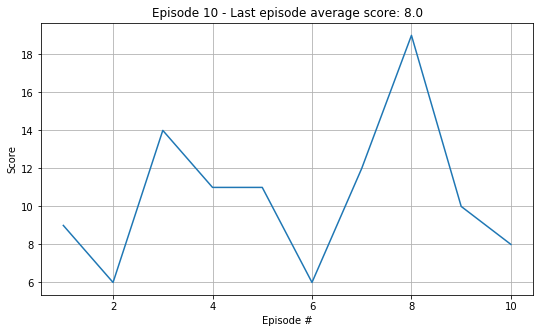

Model used ->  13-agent_model_trained_2018-11-10_230850.pth

Environment tested in 3.395366382598877 minutes!

Model total score obtained -> 106.0


In [15]:
model_file_name = "13-agent_model_trained_2018-11-10_230850.pth"

use_prioritised_replay = True
use_duelling_networks = True

test_mode = True

if test_mode == True:
    
    # echoes current task
    print("Testing started... :-)")
    
    # instantiates a new environment in test mode
    env = UnityEnvironment(file_name='Banana.app', no_graphics=True, seed=1)

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # reset the environment
    env_info = env.reset(train_mode=False)[brain_name]

    # number of agents
    num_agents = len(env_info.agents)

    # size of each action
    action_size = brain.vector_action_space_size

    # examine the state space
    state = env_info.vector_observations[0]
    state_size = state.shape[0]
    
    # starts our tests
    test()